

<a href="https://colab.research.google.com/github/JacobJ215/YOLO-NAS-OCR-WebApp/blob/main/yolonas_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Installing Packages

In [2]:
%%capture
!pip install super-gradients
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

### Import required libraries

In [1]:
import os
import torch

from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training import models
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

The console stream is logged into /root/sg_logs/console.log


[2023-08-05 20:39:40] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-08-05 20:39:52] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-08-05 20:39:56] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-08-05 20:39:56] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-08-05 20:39:56] WARNING - export.py - Failed to import pytorch_quantization
[2023-08-05 20:39:56] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


### Define checkpoint directory and instantiate the trainer


In [2]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='yolonas_license_plate', ckpt_root_dir=CHECKPOINT_DIR)

### Export Dataset from RoboFlow

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("yolotraining-dfaoh").project("ocr-nsde5")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...

### Define dataset paramters

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 2

dataset_params = {
    'data_dir': '/content/OCR-2',
    'train_images_dir': 'train/images',
    'train_labels_dir': 'train/labels',
    'val_images_dir': 'valid/images',
    'val_labels_dir': 'valid/labels',
    'test_images_dir': 'test/images',
    'test_labels_dir': 'test/labels',
    'classes': ['license_plate']
}

### Create data loaders to batch data

In [5]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
        },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
        },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
        },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS
    }
)

Extracting Dataset Version Zip to OCR-2 in yolov5pytorch:: 100%|██████████| 980/980 [00:00<00:00, 7308.89it/s]
Caching annotations: 100%|██████████| 339/339 [00:00<00:00, 6034.46it/s]


### Inspection

In [6]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

Caching annotations: 100%|██████████| 49/49 [00:00<00:00, 3250.58it/s]


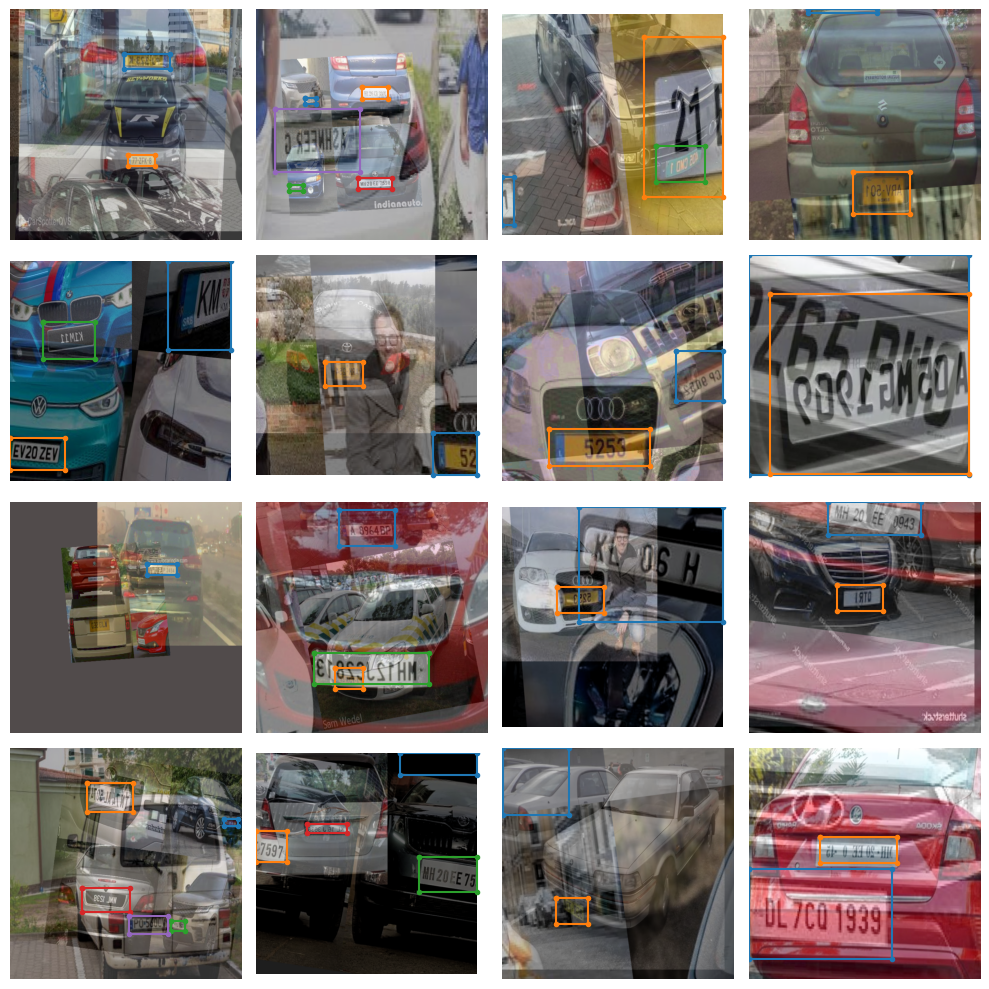

In [7]:
train_data.dataset.plot()

### Define training parameters

In [8]:
train_params = {
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

### Instantiate YOLO-NAS model

In [9]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights='coco'
)

[2023-08-05 20:40:13] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 330MB/s]


### Train the model

In [10]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/yolonas_license_plate/console_Aug05_20_40_21.txt


[2023-08-05 20:40:21] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-05 20:40:25] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 339        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         21         (len(train_loader))
    - Gradient updates per epoch:   21         (len(train_loader) / batch_accumulate)

[2023-08-05 20:41:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolonas_license_plate/ckpt_best.pth
[2023-08-05 20:41:03] INFO - sg_trainer.py - Best checkpoint overriden: va

### Load the best trained model

In [12]:
from google.colab import drive
drive.mount('/content/drive')

In [14]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path='/content/drive/MyDrive/yolo_training/Checkpoints/ckpt_best.pth')

### Evaluate best trained model

In [16]:
trainer.test(model=model,
              test_loader=test_data,
              test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                     top_k_predictions=300,
                                                     num_cls=len(dataset_params['classes']),
                                                     normalize_targets=True,
                                                     post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                            nms_top_k=1000,
                                                                                                            max_predictions=300,
                                                                                                            nms_threshold=0.7)))

Testing:  75%|███████▌  | 3/4 [00:04<00:01,  1.11s/it]

{'PPYoloELoss/loss_cls': 0.9181855,
 'PPYoloELoss/loss_iou': 0.17447565,
 'PPYoloELoss/loss_dfl': 0.9500977,
 'PPYoloELoss/loss': 1.8294234,
 'Precision@0.50': 0.02825159952044487,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.9623407125473022,
 'F1@0.50': 0.05495075136423111}

Testing: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


### Prediction

[2023-08-05 21:10:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


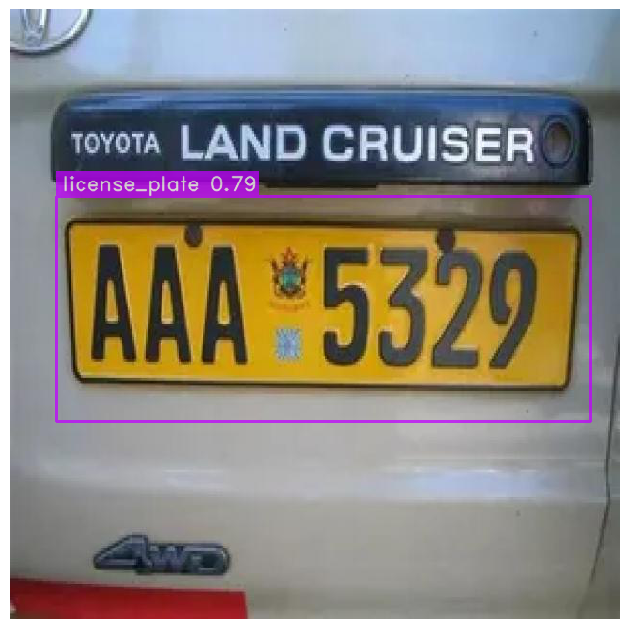

In [22]:
img_url = '/content/OCR-2/valid/images/23_jpg.rf.fb6cfdaf695583ce039887cfdc024aa2.jpg'
best_model.predict(img_url).show()